# Deep Learning 미션 중-1
## Convolutional Neural Networks를 직접 구성하여 99% 이상의 성능을 내는 MNIST 분류기 만들기

1. Convolution 연산, Flatten 연산, Fully Connected 레이어, Activation 연산만을 가지고 MNIST 분류기 만들기
2. 1.에 Max Pooling, Average Pooling 레이어를 추가하여 MNIST 분류기 만들기
3. 2의 Pooling연산을 제거하고 Adaptive Pooling을 적절히 활용하여 MNIST  분류기 만들기

In [77]:
# 라이브러리 호출

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # 진행상태 확인을 위한 로딩바 생성
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T # tensor형태로 변환하기 위한 라이브러리
import torchvision
from torchsummary import summary

from sklearn.metrics import accuracy_score

# data load

In [78]:
transform = T.Compose([
    T.ToTensor()
])

In [79]:
# 데이터 다운로드
download_root = './MNIST_DATASET'

train_dataset = torchvision.datasets.MNIST(download_root, transform=transform, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(download_root, transform=transform, train=False, download=True)

In [80]:
total_size = len(train_dataset)
train_num, valid_num = int(total_size*0.8), int(total_size*0.2)
print('Train dataset 개수: {}'.format(train_num))
print('Valid dataset 개수: {}'.format(valid_num))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

Train dataset 개수: 48000
Valid dataset 개수: 12000


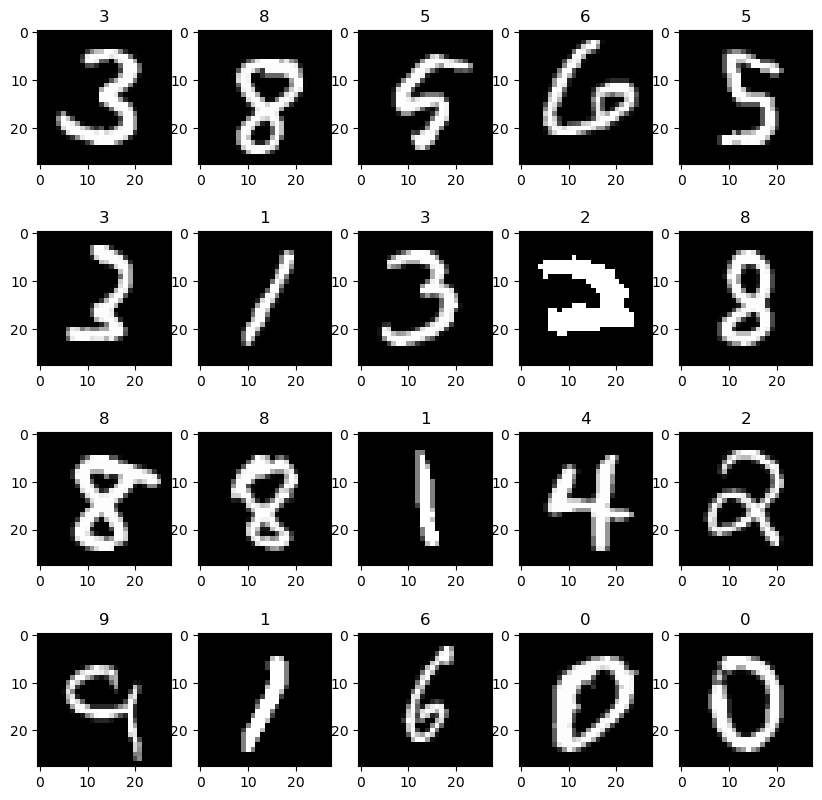

In [81]:
# train data 확인
plt.figure(figsize=(10, 10))

for i in range(20):
    image = train_dataset[i][0].squeeze().numpy()
    label = train_dataset[i][1]

    ax = plt.subplot(4, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(label)

### dataloader

In [82]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [83]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 1, 28, 28])
tensor([8, 0, 0, 2, 0, 1, 3, 4, 7, 1, 2, 8, 9, 2, 9, 9, 9, 6, 1, 7, 3, 5, 3, 1,
        0, 9, 2, 3, 3, 4, 2, 7])


# Model 생성

## 1. Convolution, Flatten, FC, Activation만 사용

In [21]:
class Model_1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True)
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True)
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True)
        )

        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True)
        )

        self.block5 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*128, 1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, 10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        output = self.block5(x)

        return output
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [22]:
model = Model_1()
print(summary(model, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           9,248
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 14, 14]          18,496
             ReLU-10           [-1, 64, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          36,928
             ReLU-12           [-1, 64, 14, 14]               0
           Conv2d-13            [-1, 128, 7, 7]          73,856
             ReLU-14            [-1, 12

In [23]:
model.count_parameters()

7394298

### Model 학습

In [24]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

In [25]:
def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

In [26]:
def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model,train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [27]:
model = Model_1()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 3)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 2.333207643826803, Train Accuracy: 0.1251875
Valid Loss: 2.3236963342030843, Valid Accuracy: 0.13741666666666666


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 2.32398397954305, Train Accuracy: 0.13716666666666666
Valid Loss: 2.3212338644663495, Valid Accuracy: 0.13991666666666666


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 2.367088141441345, Train Accuracy: 0.0940625
Valid Loss: 2.3769839795430503, Valid Accuracy: 0.08416666666666667


### Model 테스트

In [28]:
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        
        total_preds.extend(predicted.tolist())
        total_labels.extend(labels.tolist())

  0%|          | 0/313 [00:00<?, ?it/s]

In [29]:
total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
custom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("accuracy : ", custom_cnn_acc)

accuracy :  0.0831


## 2. Pooling 추가

In [47]:
class Model_2(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )

        self.block5 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*128, 1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, 10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        output = self.block5(x)

        return output
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [48]:
model = Model_2()
print(summary(model, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 28, 28]               0
            Conv2d-6           [-1, 32, 28, 28]           4,640
              ReLU-7           [-1, 32, 28, 28]               0
            Conv2d-8           [-1, 32, 28, 28]           9,248
              ReLU-9           [-1, 32, 28, 28]               0
        MaxPool2d-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          18,496
             ReLU-12           [-1, 64, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          36,928
             ReLU-14           [-1, 64,

### Model 학습

In [50]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

In [51]:
def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

In [ ]:
def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model,train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [52]:
model = Model_2()

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 3)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3734510292306077, Train Accuracy: 0.8720416666666667
Valid Loss: 0.10733496109737704, Valid Accuracy: 0.96775


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.08982266889485375, Train Accuracy: 0.9735208333333333
Valid Loss: 0.08412824650341645, Valid Accuracy: 0.97575


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.06611425467683148, Train Accuracy: 0.9811458333333334
Valid Loss: 0.06911942238492581, Valid Accuracy: 0.9795


### Model 테스트

In [53]:
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        
        total_preds.extend(predicted.tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
custom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("accuracy : ", custom_cnn_acc)

  0%|          | 0/313 [00:00<?, ?it/s]

accuracy :  0.9807


## 3. BatchNorm2d 추가

In [56]:
class Model_3(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )

        self.block5 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*128, 1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, 10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        output = self.block5(x)

        return output
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [57]:
model = Model_3()
print(summary(model, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,320
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 28, 28]               0
            Conv2d-8           [-1, 32, 28, 28]           4,640
              ReLU-9           [-1, 32, 28, 28]               0
      BatchNorm2d-10           [-1, 32, 28, 28]              64
           Conv2d-11           [-1, 32, 28, 28]           9,248
             ReLU-12           [-1, 32, 28, 28]               0
      BatchNorm2d-13           [-1, 32, 28, 28]              64
        MaxPool2d-14           [-1, 32,

### Model 학습

In [58]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

In [59]:
def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()
        max_probm, predicted = torch.max(outputs, 1)
        valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

In [60]:
def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [61]:
model = Model_3()

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 3)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.2329800202526773, Train Accuracy: 0.9348333333333333
Valid Loss: 0.0976725388977599, Valid Accuracy: 0.9735833333333334


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.07989517283972236, Train Accuracy: 0.9778333333333333
Valid Loss: 0.08729330370241466, Valid Accuracy: 0.97975


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.06531053886657537, Train Accuracy: 0.9831875
Valid Loss: 0.0654024115294645, Valid Accuracy: 0.9838333333333333


### Model 테스트

In [64]:
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        
        total_preds.extend(predicted.tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
custom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("accuracy : ", custom_cnn_acc)

  0%|          | 0/313 [00:00<?, ?it/s]

accuracy :  0.9843


## 4. adaptive pooling

In [86]:
class Model_4(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.cv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.cv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        
        self.pool = torch.nn.AdaptiveAvgPool2d(output_size=7)
        self.norm1 = torch.nn.BatchNorm2d(num_features=16)
        self.norm2 = torch.nn.BatchNorm2d(num_features=32)
        self.norm3 = torch.nn.BatchNorm2d(num_features=64)

        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.Linear(7*7*64, 512)
        self.dense2 = torch.nn.Linear(512, 10)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.cv1(x)
        x = self.relu(x)
        x = self.norm1(x)

        x = self.cv2(x)
        x = self.relu(x)
        x = self.norm2(x)

        x = self.cv3(x)
        x = self.relu(x)
        x = self.norm3(x)

        x = self.pool(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)

        return x

In [87]:
model = Model_4()
print(summary(model, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
       BatchNorm2d-9           [-1, 64, 28, 28]             128
AdaptiveAvgPool2d-10             [-1, 64, 7, 7]               0
          Flatten-11                 [-1, 3136]               0
           Linear-12                  [-1, 512]       1,606,144
             ReLU-13                  [-1, 512]               0
           Linear-14                   

In [88]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

In [89]:
def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()
        max_probm, predicted = torch.max(outputs, 1)
        valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

In [90]:
def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [93]:
model = Model_4()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.10160382265247365, Train Accuracy: 0.9684166666666667
Valid Loss: 0.07394768098896991, Valid Accuracy: 0.9775


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.042597277605183385, Train Accuracy: 0.9866875
Valid Loss: 0.04931336856080452, Valid Accuracy: 0.9869166666666667


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.031394431306347545, Train Accuracy: 0.9905833333333334
Valid Loss: 0.038866416338836036, Valid Accuracy: 0.98975


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.023715360142379724, Train Accuracy: 0.9930625
Valid Loss: 0.04003941049895366, Valid Accuracy: 0.99


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.01540965932652307, Train Accuracy: 0.994875
Valid Loss: 0.056272599262431264, Valid Accuracy: 0.9883333333333333


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.016994267058154468, Train Accuracy: 0.9948125
Valid Loss: 0.05547030245667884, Valid Accuracy: 0.98875


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.010200739319333924, Train Accuracy: 0.996875
Valid Loss: 0.04507215430602228, Valid Accuracy: 0.9913333333333333


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.009698637186062854, Train Accuracy: 0.9972291666666667
Valid Loss: 0.04191543583026408, Valid Accuracy: 0.9924166666666666


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.009363083265831039, Train Accuracy: 0.997125
Valid Loss: 0.04933157633637254, Valid Accuracy: 0.9906666666666667


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.007309980144760743, Train Accuracy: 0.9976875
Valid Loss: 0.07197676310543023, Valid Accuracy: 0.9885


In [94]:
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        
        total_preds.extend(predicted.tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
custom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("accuracy : ", custom_cnn_acc)

  0%|          | 0/313 [00:00<?, ?it/s]

accuracy :  0.9874
